In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
#!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

Streaming output truncated to the last 5000 lines.
  inflating: /data/test/Elmar_Brok_30.jpg  
  inflating: /data/test/Elmar_Brok_31.jpg  
  inflating: /data/test/Elsa_Zylberstein_00.jpg  
  inflating: /data/test/Elsa_Zylberstein_01.jpg  
  inflating: /data/test/Elsa_Zylberstein_10.jpg  
  inflating: /data/test/Elsa_Zylberstein_11.jpg  
  inflating: /data/test/Elsa_Zylberstein_40.jpg  
  inflating: /data/test/Elsa_Zylberstein_41.jpg  
  inflating: /data/test/Elton_John_10.jpg  
  inflating: /data/test/Elton_John_11.jpg  
  inflating: /data/test/Elton_John_20.jpg  
  inflating: /data/test/Elton_John_21.jpg  
  inflating: /data/test/Elton_John_30.jpg  
  inflating: /data/test/Elton_John_31.jpg  
  inflating: /data/test/Elton_John_40.jpg  
  inflating: /data/test/Elton_John_41.jpg  
  inflating: /data/test/Emile_Lahoud_00.jpg  
  inflating: /data/test/Emile_Lahoud_01.jpg  
  inflating: /data/test/Emile_Lahoud_30.jpg  
  inflating: /data/test/Emile_Lahoud_31.jpg  
  inflating: /data/test/E

In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
#from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
#%load_ext autoreload
#%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import Net 

net = Net()
print(net)
#from torchsummary import summary
#summary(net, (1,224,224))

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_drop): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4_drop): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=36864, out_features=136, bias=True)
)


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils 
from data_load import FacialKeypointsDataset

from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([Rescale(250), 
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

#test that you have actually defined the transform
assert(data_transform is not None), 'Define a Data Transform'

In [6]:
#Now Create the Transformed Dataset
transformed_dataset = FacialKeypointsDataset(csv_file = '/data/training_frames_keypoints.csv',
                                             root_dir = '/data/training/',
                                             transform = data_transform)
print('Number of Images in Dataset:', len(transformed_dataset))

for i in range(4):
  sample = transformed_dataset[i]
  print(i, sample['image'].shape, sample['keypoints'].shape)

Number of Images in Dataset: 3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


**BATCHING AND LOADING DATA**

After transforming dataset, we use PyTorch's Dataloader class to load the training data in batches of whatever size as well as shuffle the data for training tha model

Batch size should neither be too big or too small. A large batch size may cause the model to crash and/or run out of memory while training 

In [7]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 0)

In [8]:
# Now Load Test Dataset and Transform it as well

test_dataset = FacialKeypointsDataset(csv_file = '/data/test_frames_keypoints.csv',
                                      root_dir = '/data/test/',
                                      transform = data_transform)

In [9]:
batch_size = 10

test_loader = DataLoader(transformed_dataset,
                         batch_size = batch_size,
                         shuffle = True,
                         num_workers = 0)

In [10]:
# test the model on a batch of test images
def net_sample_output():
  for i, sample in enumerate(test_loader):

    #get sample data: images and ground truth keypoints
    images = sample['image']
    key_pts = sample['keypoints']

    #Convert images to Float Tensors
    images = images.type(torch.FloatTensor)

    #forward pass to get net output
    output_pts = net(images)

    #reshape to batch_size x 68 x 2 pts
    output_pts = output_pts.view(output_pts.size()[0], 68, -1)

    #break after first image is tested
    if i ==0:
      return images, output_pts, key_pts

In [11]:
test_images, test_outputs, gt_pts = net_sample_output()
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


**VISUALIZE THE PREDICTED KEYPOINTS**

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a new function, show_all_keypoints that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts = None):
  """Show image with predicted keypoints"""

  # image is in grayscale
  plt.imshow(image, cmap='gray')
  plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker = '.', c = 'm') # c is color

  #plot ground truth (gt) points in green
  plt.scatter(gt_pts[:,0], gt_pts[:,1], s=20, marker = '.', c = 'g')




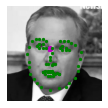

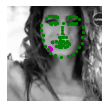

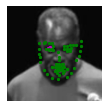

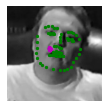

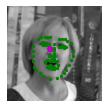

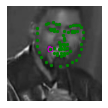

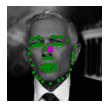

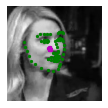

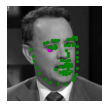

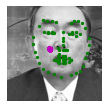

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100 #un normalizing groung truth points
        
        # call show_all_keypoints 
        # np.squeeze removes a dimension from the selected axis
        # Returns an input array, but with all or a subset of the dimensions of length 1 removed
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

Define Loss and Optimizer


In [14]:
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)

**TRAINING AND OBSERVATION FOR MODIFYING HYPERPARAMETERS**

In [15]:
def train_net(num_epochs):

  #prepare the net for training
  net.train()
  training_loss = []
  #iters = []

  for epoch in range(num_epochs):
    running_loss = 0.0

    #train on batches of data from train_loader
    for batch_i, data in enumerate(train_loader):
      # get input images and their keypoints
      images = data['image']
      key_pts = data['keypoints']

      # flatten pts
      key_pts = key_pts.view(key_pts.size(0), -1)

      # convert variables to float to alculate regression loss
      key_pts = key_pts.type(torch.FloatTensor)
      images = images.type(torch.FloatTensor)

      # forward pass to get output
      output_pts = net(images)

      #calculate loss between predicted and target keypoints
      loss = criterion(output_pts, key_pts)

      #zero the parameter (weight) gradients  WHY? so that gradients from the previous batch do not
      #interfere with the gradients of the next batch
      optimizer.zero_grad()

      #backward pass to calculate weight gradients
      loss.backward()

      # update the weights
      optimizer.step()

      # print loss statistics
      running_loss = running_loss + loss.item()
      #iters.append(epoch)
      #training_loss.append(running_loss/10)


      if batch_i % 10 == 9:
        print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch+1, batch_i+1, running_loss/10))
        training_loss.append(running_loss/10)
        running_loss = 0.0

  print('Fininshed Training')

  #plt.plot(iters, training_loss)
  #plt.xlabel('10s  of batches')
  #plt.ylabel('loss')
  #plt.xlim(0, 350)
  #plt.ylim(0, 4)
  #plt.show()


In [16]:
# Visualising loss 
n_epochs = 30
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.33704820424318316
Epoch: 1, Batch: 20, Avg. Loss: 0.20152874886989594
Epoch: 1, Batch: 30, Avg. Loss: 0.19466803818941117
Epoch: 1, Batch: 40, Avg. Loss: 0.16910746395587922
Epoch: 1, Batch: 50, Avg. Loss: 0.15359018221497536
Epoch: 1, Batch: 60, Avg. Loss: 0.16998548954725265
Epoch: 1, Batch: 70, Avg. Loss: 0.1915905363857746
Epoch: 1, Batch: 80, Avg. Loss: 0.19481589049100875
Epoch: 1, Batch: 90, Avg. Loss: 0.18576038777828216
Epoch: 1, Batch: 100, Avg. Loss: 0.16813673153519632
Epoch: 1, Batch: 110, Avg. Loss: 0.19855405688285827
Epoch: 1, Batch: 120, Avg. Loss: 0.16471681147813796
Epoch: 1, Batch: 130, Avg. Loss: 0.22368870973587035
Epoch: 1, Batch: 140, Avg. Loss: 0.1926878422498703
Epoch: 1, Batch: 150, Avg. Loss: 0.18668019250035287
Epoch: 1, Batch: 160, Avg. Loss: 0.18145653381943702
Epoch: 1, Batch: 170, Avg. Loss: 0.16970764100551605
Epoch: 1, Batch: 180, Avg. Loss: 0.22139342576265336
Epoch: 1, Batch: 190, Avg. Loss: 0.16937740296125411
Epoc

In [17]:
# Get a sample of test data again
test_images, test_outputs, get_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(get_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


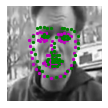

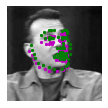

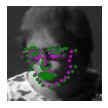

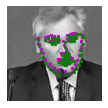

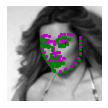

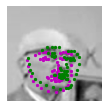

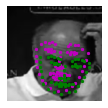

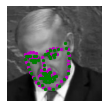

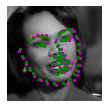

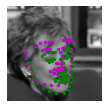

In [19]:
# Visualizing Test Output

visualize_output(test_images, test_outputs, get_pts)
